# ETL


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Air Quality

### Importamos los Datos

In [2]:
aire = pd.read_csv("../raw_data/air_quality.csv")
aire

,Unique ID,Indicator ID,Name,Measure,Measure Info,Geo Type Name,Geo Join ID,Geo Place Name,Time Period,Start_Date,Data Value,Message
0,179772,640,Boiler Emissions- Total SO2 Emissions,Number per km2,number,UHF42,409.0,Southeast Queens,2015,01/01/2015,0.3,NaN
1,179785,640,Boiler Emissions- Total SO2 Emissions,Number per km2,number,UHF42,209.0,Bensonhurst - Bay Ridge,2015,01/01/2015,1.2,NaN
2,178540,365,Fine particles (PM 2.5),Mean,mcg/m3,UHF42,209.0,Bensonhurst - Bay Ridge,Annual Average 2012,12/01/2011,8.6,NaN
3,178561,365,Fine particles (PM 2.5),Mean,mcg/m3,UHF42,409.0,Southeast Queens,Annual Average 2012,12/01/2011,8.0,NaN
4,823217,365,Fine particles (PM 2.5),Mean,mcg/m3,UHF42,409.0,Southeast Queens,Summer 2022,06/01/2022,6.1,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
18020,816914,643,Annual vehicle miles traveled,Million miles,per square mile,CD,503.0,Tottenville and Great Kills (CD3),2019,01/01/2019,12.9,NaN
18021,816913,643,Annual vehicle miles traveled,Million miles,per square mile,CD,503.0,Tottenville and Great Kills (CD3),2010,01/01/2010,14.7,NaN
18022,816872,643,Annual vehicle miles traveled,Million miles,per square mile,UHF42,208.0,Canarsie - Flatlands,2010,01/01/2010,43.4,NaN
18023,816832,643,Annual vehicle miles traveled,Million miles,per square mile,UHF42,407.0,Southwest Queens,2010,01/01/2010,65.8,NaN


### Comprobamos Nulos


In [3]:
aire.isnull().sum()

Unique ID             0
Indicator ID          0
Name                  0
Measure               0
Measure Info          0
Geo Type Name         0
Geo Join ID           9
Geo Place Name        9
Time Period           0
Start_Date            0
Data Value            0
Message           18025
dtype: int64

Debido a que toda la columna Message contiene únicamente valores nulos, se procede a su eliminación.

In [4]:
aire = aire.drop('Message', axis=1)

Las columnas Geo Join ID y Geo Place Name contienen 9 valores nulos que serán reemplazados por SD = Sin Dato.

In [5]:
aire[['Geo Join ID', 'Geo Place Name']] = aire[['Geo Join ID', 'Geo Place Name']].fillna('SD')

### Chequeo Duplicados

No hay filas duplicadas.

In [6]:
aire[aire.duplicated()]

,Unique ID,Indicator ID,Name,Measure,Measure Info,Geo Type Name,Geo Join ID,Geo Place Name,Time Period,Start_Date,Data Value


### Start Date

De esta columna se extraerá el año y el mes para posteriores análisis, por ende, se crean nuevas columnas y se borra la existente junto con Time Period.

In [7]:
#  Se cambia el tipo de dato a Datetime
aire['Start_Date'] = pd.to_datetime(aire['Start_Date'].astype(str).str.strip(), format='mixed', errors='coerce')

In [8]:
# Se extrae el año y se crea una nueva columna
aire['year'] = aire['Start_Date'].dt.year

In [9]:
# Se extrae el mes y se crea una nueva columna
aire['month'] = aire['Start_Date'].dt.month

In [10]:
# Se borra la columna existente
aire = aire.drop('Start_Date', axis=1)
# Se borra la columna Time Period
aire = aire.drop('Time Period', axis=1)

### Buscamos Outliers 

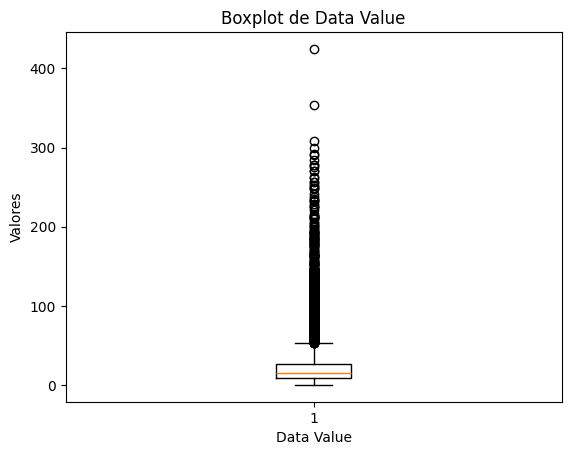

In [11]:
plt.boxplot(aire['Data Value'])
plt.title('Boxplot de Data Value')
plt.xlabel('Data Value')
plt.ylabel('Valores')
plt.show()

In [12]:
def outliers (col):
    '''
    Funcion que imprime los valores mínimo, máximo, cantidad de outliers y su porcentaje en formato de tabla
        Parámetros:
            col (str): Nombre de la columna
    '''
    Q3 = float(aire[col].quantile(0.75))
    Q1 = float(aire[col].quantile(0.25))
    RIC = Q3 - Q1

    Min = Q1 - 1.5*RIC
    Max = Q3 + 1.5*RIC

    out = aire[(aire[col]<Min)|(aire[col]>Max)]
    m = aire[col].mean()
    c = out.shape[0] 
    p = (c/aire.shape[0])*100

    print(f'| {col} | {round(m,2)} | {round(Min,2)} | {round(Max,2)} | {round(c,2)} | {round(p,2)} % |')

In [13]:
outliers('Data Value')

| Data Value | 21.43 | -17.8 | 53.4 | 980 | 5.44 % |


La columna Data Value del dataframe AIRE contiene 980 outliers, los cuales representan el 5.44% del total de los datos, estos se proceden a eliminar para mantener la mayor consistencia posible.

In [14]:
# Eliminación de Outliers
Q3 = float(aire['Data Value'].quantile(0.75))
Q1 = float(aire['Data Value'].quantile(0.25))
RIC = Q3 - Q1

Min = Q1 - 1.5*RIC
Max = Q3 + 1.5*RIC

aire = aire[(aire['Data Value'] >= Min) & (aire['Data Value'] <= Max)]

### Observaciones:

- Hay presencia de 9 valores nulos en las columnas Geo Type Name y Geo Joiny. En la columna Message todos sus valores son nulos.
- No hay valores duplicados.
- Hay 980 outliers.

## Noise Polution


### Importamos los Datos

In [15]:
noise = pd.read_csv('../raw_data/noise_pollution.csv')
noise

,split,sensor_id,audio_filename,annotator_id,borough,block,latitude,longitude,year,week,...,7-X_other-unknown-human-voice_proximity,8-1_dog-barking-whining_proximity,1_engine_presence,2_machinery-impact_presence,3_non-machinery-impact_presence,4_powered-saw_presence,5_alert-signal_presence,6_music_presence,7_human-voice_presence,8_dog_presence
0,test,0,00_026884.wav,-6,1,547,40.72951,-73.99388,2019,43,...,-1,-1,-1,1,0,-1,-1,-1,-1,-1
1,test,0,00_026884.wav,-4,1,547,40.72951,-73.99388,2019,43,...,-1,-1,1,-1,-1,-1,-1,-1,-1,-1
2,test,0,00_026884.wav,-3,1,547,40.72951,-73.99388,2019,43,...,-1,-1,1,-1,-1,-1,-1,-1,-1,-1
3,test,0,00_026884.wav,-1,1,547,40.72951,-73.99388,2019,43,...,-1,-1,-1,0,0,-1,-1,-1,-1,-1
4,test,0,00_026884.wav,0,1,547,40.72951,-73.99388,2019,43,...,-1,-1,1,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62017,validate,46,46_020807.wav,5399,1,559,40.73365,-73.98879,2018,42,...,-1,-1,0,0,0,0,1,0,0,0
62018,validate,46,46_020807.wav,5424,1,559,40.73365,-73.98879,2018,42,...,-1,-1,0,0,0,0,1,0,1,0
62019,validate,46,46_020853.wav,5337,1,559,40.73365,-73.98879,2018,34,...,far,-1,0,0,0,0,0,0,1,0
62020,validate,46,46_020853.wav,5365,1,559,40.73365,-73.98879,2018,34,...,-1,-1,0,0,0,0,0,0,0,0


### Comprobamos Nulos

In [16]:
noise.isnull().sum()

split                      0
sensor_id                  0
audio_filename             0
annotator_id               0
borough                    0
                          ..
4_powered-saw_presence     0
5_alert-signal_presence    0
6_music_presence           0
7_human-voice_presence     0
8_dog_presence             0
Length: 78, dtype: int64

Se puede observar que no hay valores nulos en ninguna columna.

### Chequeo Duplicados

In [17]:
noise[noise.duplicated()]

,split,sensor_id,audio_filename,annotator_id,borough,block,latitude,longitude,year,week,...,7-X_other-unknown-human-voice_proximity,8-1_dog-barking-whining_proximity,1_engine_presence,2_machinery-impact_presence,3_non-machinery-impact_presence,4_powered-saw_presence,5_alert-signal_presence,6_music_presence,7_human-voice_presence,8_dog_presence


Podemos ver que no hay datos duplicados.

### Columnas Innecesarias

Podemos observar que hay muchas columnas que no son de utilidad para este estudio, por ende, solo se dejan las columnas que tienen datos acerca de motores de carro, ubicaciones y tiempos.

In [18]:
noise.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62022 entries, 0 to 62021
Data columns (total 78 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   split                                         62022 non-null  object 
 1   sensor_id                                     62022 non-null  int64  
 2   audio_filename                                62022 non-null  object 
 3   annotator_id                                  62022 non-null  int64  
 4   borough                                       62022 non-null  int64  
 5   block                                         62022 non-null  int64  
 6   latitude                                      62022 non-null  float64
 7   longitude                                     62022 non-null  float64
 8   year                                          62022 non-null  int64  
 9   week                                          62022 non-null 

In [19]:
columnas_a_utilizar= ['borough', 'block', 'latitude', 'longitude', 'year', 'week', 'day', 'hour', '1-1_small-sounding-engine_presence','1-2_medium-sounding-engine_presence', '1-3_large-sounding-engine_presence', '1-X_engine-of-uncertain-size_presence', '1_engine_presence']
noise = noise[columnas_a_utilizar]

### Transformaciones Adicionales

In [20]:
# Para mejor aprovechamiento del espacio se procederá a cambios de nombres de las columnas con nombres muy largos
noise = noise.rename(columns={'1-1_small-sounding-engine_presence': 'small-engine',
                              '1-2_medium-sounding-engine_presence': 'medium-engine', 
                              '1-3_large-sounding-engine_presence': 'large-engine', 
                              '1-X_engine-of-uncertain-size_presence': 'engine-of-uncertain-size', 
                              '1_engine_presence': 'engine'})

In [21]:
# Se transforman los valores numéricos de 1, 0, y -1 en etiquetas de texto más descriptivas para facilitar la interpretación.
columns_to_replace = [
    'small-engine',
    'medium-engine',
    'large-engine',
    'engine-of-uncertain-size',
    'engine'
]

# Diccionario de reemplazo
replacement_dict = {
    1: 'Si está presente',
    0: 'No está presente',
    -1: 'No se etiqueto'
}

# Reemplazar los valores en las columnas especificadas
noise[columns_to_replace] = noise[columns_to_replace].replace(replacement_dict)

In [22]:
# Para facilitar la interpretación de la columna Borough, se reemplazan los códigos numéricos por nombres de barrios.
borough_mapping = {
    1: 'Manhattan',
    3: 'Brooklyn',
    4: 'Queens'
}

# Asignamos el nombre del borough basado en el diccionario
noise['borough'] = noise['borough'].map(borough_mapping)

In [23]:
# Para agregar una columna de MONTH:

# Se convierte 'year' y 'week' en una fecha usando el primer día de cada semana y se extrae el mes
noise['date'] = pd.to_datetime(noise['year'].astype(str) + '-W' + noise['week'].astype(str) + '-1', format='%Y-W%W-%w')
noise['month'] = noise['date'].dt.month
# Se elimina la columna 'date'
noise = noise.drop(columns=['date'])

# Para reubicar la columna 'month' justo después de 'year'
columnas = noise.columns.tolist() 
year_index = columnas.index('year')
columnas.insert(year_index + 1, columnas.pop(columnas.index('month')))
noise = noise[columnas] 

### Observaciones

- No hay valores duplicados.
- No hay valores nulos.
- De las 78 columnas iniciales se dejarán solamente 13 para este estudio.
- Los valores de las columnas escogidas no presentan inconsistencias.
- Se agregaron algunas transformaciones adicionales para facilidad en su uso posterior.

In [24]:
aire.to_csv('../clean_data/air_quality_clean.csv', index=False)
noise.to_csv('../clean_data/noise_pollution_clean.csv', index=False)